### <a href="https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip">Dataset</a>

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from preprocess import clahe, sectioning, sectioning_valid, display_sections, hist_equalization
sys.path.append('../')
from load_images import load

In [2]:
img_size = (512, 512)
X, y, masks = load(img_size)

In [3]:
clahed_X1 = clahe(X[1])
hist_X1 = hist_equalization(clahed_X1)
clahhist = clahe(hist_X1)

<function matplotlib.pyplot.show(close=None, block=None)>

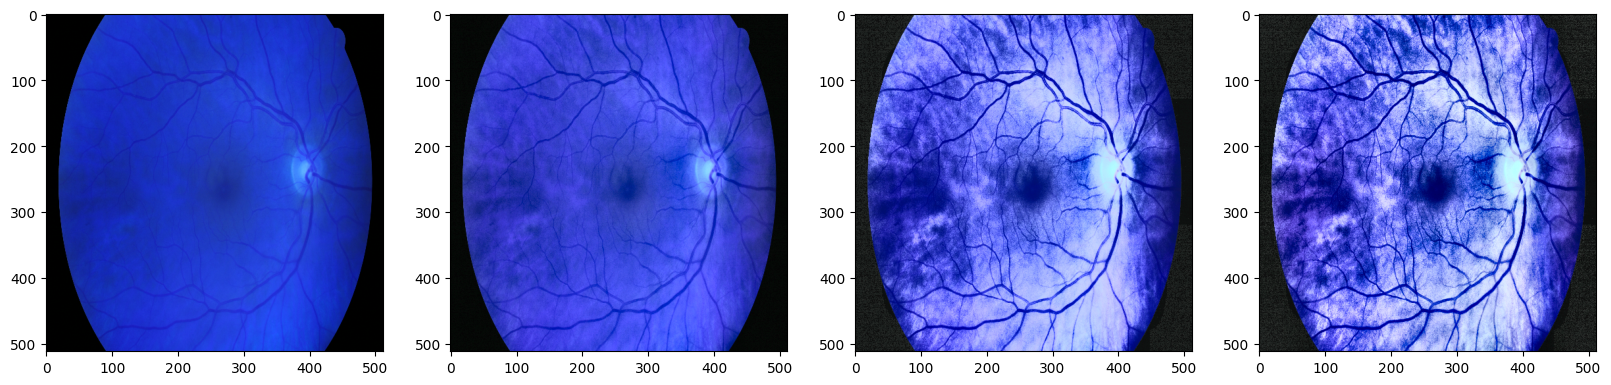

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20,15))
ax[0].imshow(X[1], cmap='gray')
ax[1].imshow(clahed_X1, cmap='gray')
ax[2].imshow(hist_X1 , cmap='gray')
ax[3].imshow(clahhist , cmap='gray')
plt.show

### Split image to NxN sections

Img padded shape:  (512, 512, 3)
Target padded shape:  (512, 512)


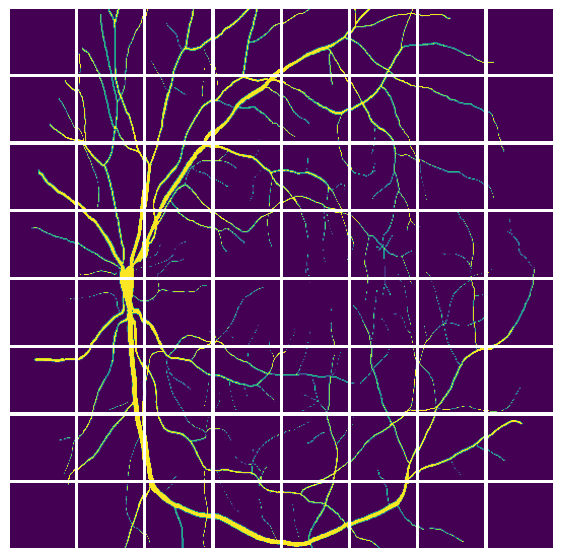

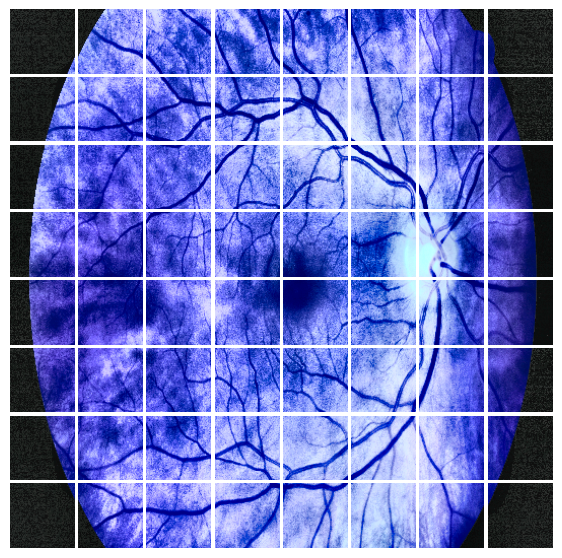

In [5]:
# Not used at proper solution - but looks cool
N = 64
sections, targets, section_size, target_size = sectioning(clahhist, y[0], N, debug=True)
display_sections(targets, target_size, N)
display_sections(sections, section_size, N)

In [7]:
# THOSE SECTION WILL BE PASSED TO CLASSIFIER WITH CORRESPONDING LABELS - PIXELS FROM TARGET IMG
sections_valid = sectioning_valid(clahhist, 5)
clahhist.shape, sections_valid.shape

512 512


((512, 512, 3), (262144, 5, 5, 3))

### Feature Extraction
TODO

In [7]:
# 5x5
# feature extraction
# colors variation
# central moments
# Hu moments

In [25]:
from scipy.stats import entropy, skew
from scipy.signal import find_peaks

In [36]:
# image -> vector of features
def feature_extraction(img, debug=False):
    
    # MEAN INTENISTY
    mean = np.mean(img)

    # STANDARD DEVIATION
    std = np.std(img)
    
    # HISTOGRAM FEATURES
    # converting to grayscale or extracting only green channel??
    green_channel = img[:,:,1]
    histogram, _ = np.histogram(green_channel.flatten(), bins=256, range=[0,256])
    peaks, _ = find_peaks(histogram)
    peaks_no = len(peaks)
    entropy_value = entropy(histogram)
    skewness_value = skew(histogram)
    
    if debug:
        print('Mean: ', mean)
        print('Std: ', std)
        print('Peaks No.: ', peaks_no)
        print('Entropy: ', entropy_value)
        print('Skewness: ', skewness_value)

In [37]:
feature_extraction(sections[0], debug=True)

Mean:  30.463704427083332
Std:  21.665739811733175
Peaks No.:  39
Entropy:  2.817190939616359
Skewness:  6.169398427316204
